# Assign1: Binary Classification




Task: Building a logistic regression model for a sentiment classification task. The dataset used was 36547 reviews on Amazon classified as negative (1 or 2 star) or positive (4 or 5 star).

### Data Preprocessing
The code for reading in, preprocessing, word2vec encoding the data is as follows.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from tqdm import tqdm
import pandas as pd

## Download w2v embeddings
import gensim.downloader as api
w = api.load('word2vec-google-news-300')
vocab=[x for x in w.key_to_index.keys()]


## Data Loading
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

## Create lists
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
  # iterate over the lines in the file
   for line in f.readlines()[1:]:
        # split the current line into a list of two element - the review and the labels
        fields = line.rstrip().split('\t')
        # put the current review in the reviews list
        reviews.append(fields[0])
        # put the current sentiment rating in the sentiment_rating list
        sentiment_ratings.append(fields[1])
        # put the current product types in the product_types list
        product_types.append(fields[2])
        # put the current helpfulness marking in the helpfulness_ratings list
        helpfulness_ratings.append(fields[3])

## Text Processing
import re
# Tokenizes each review using regex to split on whitespace
tokenized_sents = [re.findall("[^ ]+",txt) for txt in reviews]
# Combines all tokens into a single list
tokens=[]
for s in tokenized_sents:
      tokens.extend(s)
# Creates a set of unique tokens (types)
types=set(tokens)

## Word Vector Processing
# Get indices of words that exist in the Word2Vec vocabulary
vocab_dict = {word: idx for idx, word in enumerate(vocab)}
indices = [vocab_dict[x] for x in types if x in vocab_dict]
# Create a list of included types
vocab_set = set(vocab)  # 将vocab转换为集合
types_inc = [x for x in types if x in vocab_set]
# Extract corresponding word vectors from Word2Vec model
M=w[indices]
M.shape


## Generate Review Embeddings
from tqdm import tqdm
types_inc_dict = {word: idx for idx, word in enumerate(tqdm(types_inc, desc="Creating lookup dictionary"))}
embeddings = []
for rev in tqdm(reviews, desc="Generating embeddings"):
    tokens = re.findall("[^ ]+", rev)
    # 初始化为形状(1, 300)的零向量
    this_vec = np.zeros((1, 300))
    # 使用列表推导获取所有有效token的索引
    token_indices = [types_inc_dict[t] for t in tokens if t in types_inc_dict]
    if token_indices:
      # 保持形状为(1, 300)
        this_vec = np.sum(M[token_indices], axis=0).reshape(1, -1)
    embeddings.append(this_vec)

import pandas as pd
df = pd.DataFrame(np.vstack(embeddings),
                 columns=[f"dim_{i}" for i in range(300)])
df.to_csv("embeddings.csv", index=False)

# convert to a numpy array
embeddings=np.array(embeddings).squeeze()




[==================================================] 100.0% 1662.8/1662.8MB downloaded
--2025-01-16 15:49:27--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt’

Compiled_Reviews.tx 100%[===================>]  21.29M  --.-KB/s    in 0.1s    

2025-01-16 15:49:27 (148 MB/s) - ‘Compiled_Reviews.txt’ saved [22322605/22322605]



Generating embeddings: 100%|██████████| 36548/36548 [00:05<00:00, 6352.49it/s]


build training and test data from the imported data as follows

In [3]:
## split training and test data
import math
import matplotlib.pyplot as plt
import numpy as np

train_ints=np.random.choice(len(embeddings),int(len(embeddings)*0.8),replace=False)
test_ints=list(set(range(0,len(embeddings))) - set(train_ints))
# These are the training embeddings
M_train_emb = embeddings[train_ints,]
# These are the test embeddings
M_test_emb = embeddings[test_ints,]
# These are the training labels
sentiment_train = [sentiment_ratings[i] for i in train_ints]
# These are the test labels
sentiment_test = [sentiment_ratings[i] for i in test_ints]

print(M_train_emb.shape)
print(M_test_emb.shape)

(29238, 300)
(7310, 300)


### Fit the Model
Fit logistic regression models using the embedding-based representation of the reviews data. Train on the training data. Calculate precision and recall for the classifier on the test data.

In [4]:
num_features=300
weights = np.random.rand(num_features)
bias=np.random.rand(1)

In [5]:
import math
import matplotlib.pyplot as plt
y=[int(l == "positive") for l in sentiment_train]

In [7]:
len(y)

29238

<ipython-input-7-8263d0793710>:8: RuntimeWarning: overflow encountered in exp
  q = 1/(1+np.exp(-z)) # sigmoid function


Text(0, 0.5, 'loss')

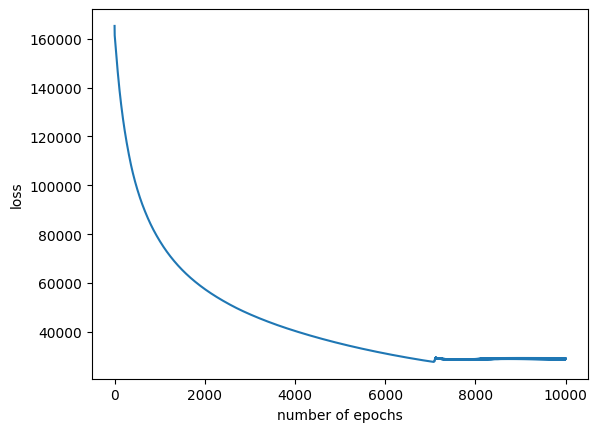

In [ ]:
n_iters = 10000
lr=0.005
logistic_loss=[]
num_samples=len(y)
for i in range(n_iters):
  z= M_train_emb.dot(weights) + bias
  # print(z)
  q = 1/(1+np.exp(-z)) # sigmoid function
  eps=0.00001 #smoothing term, avoid 0 in log
  loss_oh = -sum((y*np.log2(q+eps)+(np.ones(len(y))-y)*np.log2(np.ones(len(y))-q+eps)))
  logistic_loss.append(loss_oh)
  y_pred=[int(ql > 0.5) for ql in q]


  dw = M_train_emb.T.dot(q-y)/num_samples #注意这里，用matrix multiplication就不用sum了
  db = sum(q-y)/num_samples
  weights = weights - lr*dw
  bias =  bias - lr*db

plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

In [ ]:
z = M_test_emb.dot(weights) + bias
q = 1/(1+np.exp(-z))
y_test_pred=[int(ql > 0.5) for ql in q]

In [ ]:
labels_test_pred=["positive" if s == 1 else "negative" for s in y_test_pred]
true_positives=sum([int(yp == "positive" and sentiment_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])
true_positives=sum([int(yp == "positive" and sentiment_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])
false_positives=sum([int(yp == "positive" and sentiment_test[s] == "negative") for s,yp in enumerate(labels_test_pred)])
false_negatives=sum([int(yp == "negative" and sentiment_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])

precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
print("precision_train",precision)
print("recall",recall)

precision_train 0.8637863786378638
recall 0.6791696154753479
